# Simulating sequences with correlated and random classes

### Motivation
Here, I will generate datasets with correlated class labels and random class labels for downstream comparisons.

### Simulation overview

Two sets of simulated data will be generated, a so-called correlated labelled dataset and a randomly labelled dataset.  The correlated labelled dataset is taken from Basset's DNAse hypsersensitive site dataset.  Here, a subset of the classes are taken and the corresponding labels serve as the ground truth.  From this we create a randomly shuffled labelled dataset, importantly with the same number of labels per sequence.  A single, randomly chosen 8nt sequence motif is then associated with each class.  A synthetic sequence matrix is then created by implanting the motif's position weight matrix in a non-overlapping fashion for each sequence, depeneding on the class labels.  For isntance, if a given sequence has 5 class labels associated with it, then the 5 corresponding motifs are placed on the sequence in random order. The other nucleotide positions given by a uniform distribution, i.e. $p = 1/4$.  Then, the cumulative sum of the probabilities is calculated and a uniform random number is drawn for each nucleotide. The corresponding bin that the random number falls in determines the realized nucleotide sequence.  Each sequence is only sampled one time.  

Importantly, the correlated data and the random data have the same number of motifs, thus they presumably have the same complexity, which will allow for a fair comparison.

In [1]:
import os.path
import pandas as pd
import numpy as np
from six.moves import cPickle
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

#### Load motifs for drosophila melanogaster

The data comes from Ray et al. "A compendium of RNA-binding motifs for decoding gene regulation" (http://www.nature.com/nature/journal/v499/n7457/abs/nature12311.html). The link to the motifs I downloaded is here: 

!wget http://hugheslab.ccbr.utoronto.ca/supplementary-data/RNAcompete_eukarya/top10align_motifs.tar.gz

!tar xzf top10align_motifs.tar.gz

Here, each file is a different RBP motif as a position frequency matrix.  So, the first step is to compile all of these files into a suitable database.  In particular, we can parse each motifs (position frequency matrix) from each file in motifpath (downloaded top10align_motifs folder), create a database (list of arrays), and save as binary format (motif.list):

In [3]:
# load motifs
motiflist = 'motif.pickle'  
if os.path.isfile(motiflist):

    # load motif list from file
    f = open(motiflist, 'rb')
    motif_set = cPickle.load(f)
    f.close()

else:
    # download motifs
    motifpath = 'top10align_motifs/'   # directory where motif files are located

    # get all motif files in motifpath directory
    listdir = os.listdir(motifpath)

    # parse motifs
    motif_set = []
    for files in listdir:
        df = pd.read_table(os.path.join(motifpath,files))
        motif_set.append(df.iloc[0::,1::].transpose())

    # save motifs    
    f = open(motiflist, 'wb')
    cPickle.dump(motif_set, f, protocol=cPickle.HIGHEST_PROTOCOL)
    f.close()

Load Basset dataset 

In [4]:
# load DNAse data (courtesy of Basset)
datapath = '/home/peter/Data/Basset'
trainmat = h5py.File(os.path.join(datapath,'er.h5'), 'r')
y_train = np.array(trainmat['train_out'])
y = y_train.astype(np.float32)

Get just a subset of the Basset's DNase hypersensitive site data, specifically classes 55-105 out of 0-164. This is purely just because smaller datasets are easier to train. That means you only have to wait for hours rather than days.

In [5]:
def data_subset(y, class_range, negative=True):
    " gets a subset of data in the class_range"
    data_index = []
    for i in class_range:
        index = np.where(y[:, i] == 1)
        data_index = np.concatenate((data_index, index[0]), axis=0)
    unique_index = np.unique(data_index)
    num_data = y.shape[0]
    non_index = np.array(list(set(range(num_data)) - set(unique_index)))
    if negative:
        index = np.concatenate((unique_index, non_index), axis=0)
    else:
        index = unique_index
    return index.astype(int)

# get a subset of the Basset dataset
num_seq = 300000       # number of sequences
class_range = range(55,105)
index = data_subset(y, class_range, negative=False)
labels = y[index[0:num_seq],:]
labels = labels[:,class_range]

Let's plot the covariance structure of Basset's labelled data.  

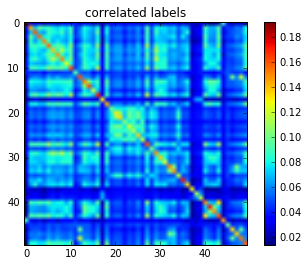

In [6]:
# plot the covariance structure of Basset's dataset
C = np.cov(labels.T)
plt.figure()
plt.imshow(C)
plt.title('correlated labels')
plt.colorbar()

You can see that there is a striking level of covariation between the labelled data. Moreover, the variance between classes (diagonal elements) are very heterogeneous.  This means that this dataset has correlations and heteroskedasticity.  Thus, each class prediction should not all be weighed the same way.  However, most over-the-counter cost functions don't account for this, such as binary cross-entropy, which is the cost function of choice for Basset, DeepSea, and DanQ.  More about this later... and solutions later too...


### Generate random class labels

To test the performance of deep learning models on datasets with correlated classes and random classes, we need to be fair and generate a comparable level of complexity so as not to create any biases.  To do this, I will use the number of labelled data for each sequence, and then randomly shuffle the class labels.  So, the total number of classes for the random class sequence will be exactly the same as the correlated class sequence, and thus similar level of complexity.  

In [7]:
# determine number of motifs to add to each sequence
num_motifs = np.sum(labels, axis=1).astype(int)
num_classes = len(class_range)

# determine labels
labels_new = np.zeros((num_seq, num_classes))
for i in range(len(num_motifs)):
    # randomly permute 
    index = np.random.permutation(num_classes)[0:num_motifs[i]]
    labels_new[i, index] = 1

Now let's plot the covariance structure of the randomly labelled sequences.  

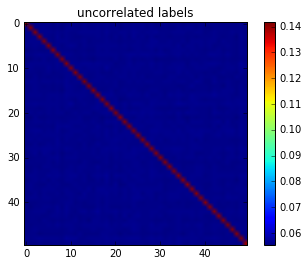

In [8]:
# plot the covariance structure of the random dataset
C2 = np.cov(labels_new.T)
plt.figure()
plt.imshow(C2)
plt.title('uncorrelated labels')
plt.colorbar()

Clearly, there are no correlations and the variances are the same as well. So, this dataset has no correlations and heteroskedasiticity. Now, we need to setup a model for each class.  For simplicity, let's just associate each class to a single 8 nucleotide sequence motif, which is randomly sampled from our list of motifs. In this way, if a motif is found, then the class should be predicted.  This is certainly overly simplistic, but we may still learn something from doing this simple exercise.

In [12]:
# select random subset of motifs from the complete list of motif_set
motifIndex = np.random.permutation(len(motif_set))[0:num_classes]
motifs = []
for index in motifIndex:
    motifs.append(motif_set[index])

Let's now generate the sequence and convert it to a one-hot matrix. For a given sequence, the class labels associated with that sequence tell us how many motifs are present.  We then shuffle these motifs and implant them on the sequence so that they don't overlap with each other.  

In [13]:
# loop through each label and generate a sequence 
def geneterate_sequence(label, motifs, seq_length):
    seq = []
    for label in labels_new:

        # find number of classes for given sequence
        # which will correspond to the number of motifs for the sequence
        index = np.where(label==1)[0]
        num_index = len(index)

        # figure out spacing between motifs
        buffer_size = seq_length - num_index*8
        ave_spacing = np.floor(buffer_size/(num_index+1))

        # generate sequence with motifs
        sequence_pwm = np.ones((4,ave_spacing))/4
        for i in index:
            sequence_pwm = np.hstack((sequence_pwm, motifs[i]))
            sequence_pwm = np.hstack((sequence_pwm, np.ones((4,ave_spacing))/4))
        sequence_pwm = np.hstack((sequence_pwm, np.ones((4,seq_length - sequence_pwm.shape[1]))/4))

        # convert to one-hot representation
        nucleotide = 'ACGU'
        cum_prob = sequence_pwm.cumsum(axis=0)
        Z = np.random.uniform(0,1,seq_length)
        one_hot_seq = np.zeros((4,seq_length))
        for i in range(seq_length):
            index=[j for j in range(4) if Z[i] < cum_prob[j,i]][0]
            one_hot_seq[index,i] = 1
        seq.append(one_hot_seq)

    # convert to numpy array
    seq = np.array(seq)
    return seq

seq_length = 600
seq_corr = geneterate_sequence(labels, motifs, seq_length)
seq_random = geneterate_sequence(labels_new, motifs, seq_length)

Let's split the data into a training set, cross-validation set, and test set with proportions 0.7, 0.15, and 0.15, respectively.  

In [14]:
def split_dataset(seq, labels, split_size):
    # generate a shuffled subset of data for train, validation, and test
    
    num_labels = len(np.unique(labels))
    cum_index = np.cumsum(np.multiply([0, split_size[0], split_size[1], split_size[2]],num_seq)).astype(int) 
    shuffle = np.random.permutation(num_seq)
    train_index = shuffle[range(cum_index[0], cum_index[1])]
    valid_index = shuffle[range(cum_index[1], cum_index[2])]
    test_index = shuffle[range(cum_index[2], cum_index[3])]

    # create subsets of data based on indices 
    train = (seq[train_index], labels[train_index])
    valid = (seq[valid_index], labels[valid_index])
    test = (seq[test_index], labels[test_index])
    return train, valid, test
    
# split dataset into training cross validation and testing
train_size = 0.7
valid_size = 0.15
test_size = 0.15
split_size = [train_size, valid_size, test_size]
train, valid, test = split_dataset(seq_corr, labels, split_size)
train2, valid2, test2 = split_dataset(seq_random, labels_new, split_size)

Now let's save the datasets as an hdf5 file.

In [15]:
def save_dataset(savepath, train, valid, test):
    f = h5py.File(savepath, "w")
    dset = f.create_dataset("trainx", data=train[0])
    dset = f.create_dataset("trainy", data=train[1])
    dset = f.create_dataset("validx", data=valid[0])
    dset = f.create_dataset("validy", data=valid[1])
    dset = f.create_dataset("testx", data=test[0])
    dset = f.create_dataset("testy", data=test[1])
    f.close()

savepath = "synthetic_correlated_motifs_"+ str(num_seq) + ".hdf5"
save_dataset(savepath, train, valid, test)

savepath = "synthetic_random_motifs_"+ str(num_seq) + ".hdf5"
save_dataset(savepath, train2, valid2, test2)